# Обнаружение краёв шахматной доски на фотографиях

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, LeakyReLU, ReLU, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import imgaug.augmenters as iaa
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage

##### Загрузка обучающей выборки

In [2]:
x_train = np.load('xtrain.npy')

In [3]:
x_train.shape

(15137, 256, 256, 1)

15137 изображений 256х256 с 1 каналом.

In [4]:
y_train = np.load('ytrain.npy')

In [5]:
y_train.shape

(15137, 8)

In [6]:
x_test = np.load('xtest.npy')

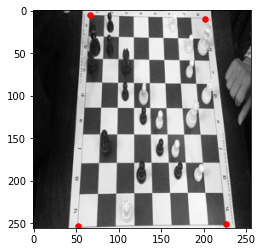

In [7]:
# Посмотрим, как выглядит элемент обучающей выборки с ключевыми точками
plt.imshow(x_train[0], cmap='Greys_r')
plt.scatter(np.array([y_train[0][0], y_train[0][2], y_train[0][4], y_train[0][6]])*256, 
            np.array([y_train[0][1], y_train[0][3], y_train[0][5], y_train[0][7]])*256, 
            s=30, color='red')
plt.show()

In [8]:
IMG_SIZE = 256
BATCH_SIZE = 64
NUM_KEYPOINTS = 4 * 2

##### Аугментация изображений

Будем использовать аугментацию изображений вместе с ключевыми точками с помощью imgaug. 

Определяем генератор батчей, осуществляющий перемешивание и аугментацию изображений.

In [9]:
class BatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_keys, aug=None, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return (self.image_keys[1] - self.image_keys[0]) // self.batch_size

    def on_epoch_end(self):
        self.indices = np.arange(self.image_keys[0], self.image_keys[1])
        if self.train:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        if self.aug is not None:
            (images, keypoints) = self.__get_batch(x_train[indices], y_train[indices])
        else:
            (images, keypoints) = (x_train[indices], y_train[indices])
        return (images, keypoints)

    def __get_batch(self, batch_x, batch_y):
        batch_images = np.empty(batch_x.shape, dtype="int")
        batch_keypoints = np.empty(batch_y.shape, dtype="float32")
            
        for key, image in enumerate(batch_x):
            kps = []
            keypoints = batch_y[key] * IMG_SIZE
            kps.append(Keypoint(x=keypoints[0], y=keypoints[1]))
            kps.append(Keypoint(x=keypoints[2], y=keypoints[3]))
            kps.append(Keypoint(x=keypoints[4], y=keypoints[5]))
            kps.append(Keypoint(x=keypoints[6], y=keypoints[7]))
            kps_obj = KeypointsOnImage(kps, shape=image.shape)

            (new_image, new_kps_obj) = self.aug(image=image, keypoints=kps_obj)
            batch_images[key] = new_image

            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(keypoint.x)
                kp_temp.append(keypoint.y)
            batch_keypoints[key] =  np.array(kp_temp).reshape((1, NUM_KEYPOINTS))

        batch_keypoints = batch_keypoints / IMG_SIZE
        return (batch_images, batch_keypoints)

In [10]:
# Параметры аугментации
train_aug = iaa.Sequential(
    [
        iaa.Affine(scale=(.9, 1.01),
                     rotate=(-5, 5), 
                     translate_percent=({'x': (-0.15, 0.15), 'y': (-0.01, 0.01)}), 
                     shear=(-6, 6), 
                     mode='edge'
        ),
        iaa.SomeOf((0, 3), 
                   [
                        iaa.Add((-10, 10)),
                        iaa.Multiply((0.9, 1.2)),
                        iaa.LinearContrast((0.9, 1.2)),
                    ], 
                   random_order=True
        )
    ]
)


Возьмем первые 15000 изображений в качестве обучающей выборки, остальные будем использовать для валидации.

In [11]:
train_keys, validation_keys = (
    (0, 15000),
    (15000, 15138),
)

In [12]:
train_generator = BatchGenerator(train_keys, aug=train_aug)
validation_generator = BatchGenerator(validation_keys, train=False)

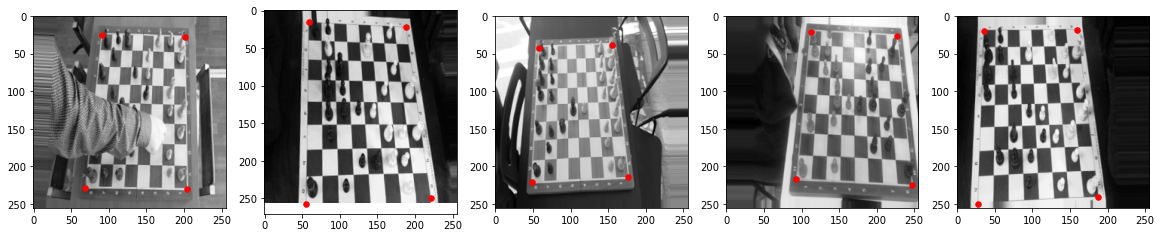

In [13]:
# Несколько примеров аугментированных изображений с ключевыми точками
aug_iter = iter(train_generator)
fig, axs = plt.subplots(1, 5, figsize=(20, 6))

for i in range(5):
    sample_images, sample_keypoints = next(aug_iter)
    axs[i].imshow(sample_images[0], cmap='Greys_r')
    axs[i].scatter(np.array([sample_keypoints[0][0], sample_keypoints[0][2], sample_keypoints[0][4], sample_keypoints[0][6]])*IMG_SIZE, 
                np.array([sample_keypoints[0][1], sample_keypoints[0][3], sample_keypoints[0][5], sample_keypoints[0][7]])*IMG_SIZE, s=30, color='red')


##### Построение модели

Строим модель сверточной сети, определяющей координаты ключевых точек. Координаты - на выходе последнего полносвязного слоя (8 координат).

In [24]:
model = models.Sequential()
model.add(Conv2D(32, (5, 5), padding='VALID', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(LeakyReLU(0.1))
model.add(BatchNormalization())
model.add(Conv2D(32, (5, 5), padding='VALID'))
model.add(LeakyReLU(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu',  padding='VALID'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation = 'relu',  padding='VALID'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation = 'relu', padding='VALID'))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding='VALID'))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(160, (3, 3), activation = 'relu', padding='SAME'))
model.add(Conv2D(160, (3, 3), activation = 'relu', padding='SAME'))
model.add(Conv2D(160, (3, 3), activation = 'relu', padding='SAME'))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation = 'relu', padding='SAME'))
model.add(Conv2D(256, (3, 3), activation = 'relu', padding='SAME'))
model.add(Conv2D(256, (3, 3), activation = 'relu', padding='SAME'))
model.add(MaxPool2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(600, activation='relu'))
model.add(layers.Dense(256, activation='sigmoid'))
model.add(layers.Dense(8))

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 252, 252, 32)      832       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 252, 252, 32)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 252, 252, 32)      128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 248, 248, 32)      25632     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 248, 248, 32)      0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 248, 248, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 124, 124, 32)     

##### Обучение модели

Используем обучение по расписанию, уменьшающее шаг градиентного спуска в зависимости от количества эпох. В качестве функции потерь используем среднеквадратическую ошибку, также наблюдаем за средней абсолютной ошибкой.

In [27]:
def lr_scheduler(epoch, lr):
    if epoch <= 30:
        return lr
    elif epoch <= 50:
        return 3e-5
    elif epoch <= 70:
        return 1e-5
    else:
        return 2e-6

In [28]:
callbacks = [LearningRateScheduler(lr_scheduler)]

In [29]:
model.compile(loss='mean_squared_error',
              optimizer=optimizers.Adam(learning_rate=2e-4),
              metrics=['mae'])
history = model.fit(train_generator, validation_data=validation_generator, callbacks=callbacks, epochs=90)

Epoch 1/90
234/234 [==============================] - 73s 309ms/step - loss: 0.0046 - mae: 0.0498 - val_loss: 0.0014 - val_mae: 0.0296
Epoch 2/90
234/234 [==============================] - 73s 311ms/step - loss: 7.7898e-04 - mae: 0.0189 - val_loss: 3.1180e-04 - val_mae: 0.0119
Epoch 3/90
234/234 [==============================] - 73s 313ms/step - loss: 2.3032e-04 - mae: 0.0099 - val_loss: 2.0259e-04 - val_mae: 0.0094
Epoch 4/90
234/234 [==============================] - 73s 313ms/step - loss: 1.7308e-04 - mae: 0.0082 - val_loss: 1.9064e-04 - val_mae: 0.0091
Epoch 5/90
234/234 [==============================] - 74s 314ms/step - loss: 1.4918e-04 - mae: 0.0073 - val_loss: 1.4798e-04 - val_mae: 0.0074
Epoch 6/90
234/234 [==============================] - 74s 314ms/step - loss: 1.3426e-04 - mae: 0.0068 - val_loss: 1.3634e-04 - val_mae: 0.0069
Epoch 7/90
234/234 [==============================] - 74s 315ms/step - loss: 1.2081e-04 - mae: 0.0062 - val_loss: 1.3003e-04 - val_mae: 0.0063
Epoch 8

234/234 [==============================] - 74s 317ms/step - loss: 6.6474e-05 - mae: 0.0028 - val_loss: 7.6775e-05 - val_mae: 0.0029
Epoch 59/90
234/234 [==============================] - 74s 316ms/step - loss: 6.6364e-05 - mae: 0.0028 - val_loss: 7.6621e-05 - val_mae: 0.0029
Epoch 60/90
234/234 [==============================] - 74s 316ms/step - loss: 6.8012e-05 - mae: 0.0028 - val_loss: 7.6674e-05 - val_mae: 0.0029
Epoch 61/90
234/234 [==============================] - 74s 316ms/step - loss: 6.7894e-05 - mae: 0.0028 - val_loss: 7.6573e-05 - val_mae: 0.0029
Epoch 62/90
234/234 [==============================] - 74s 316ms/step - loss: 6.7481e-05 - mae: 0.0028 - val_loss: 7.6656e-05 - val_mae: 0.0029
Epoch 63/90
234/234 [==============================] - 74s 316ms/step - loss: 6.8449e-05 - mae: 0.0028 - val_loss: 7.6542e-05 - val_mae: 0.0029
Epoch 64/90
234/234 [==============================] - 74s 316ms/step - loss: 6.7207e-05 - mae: 0.0028 - val_loss: 7.7041e-05 - val_mae: 0.0030
Epoc

Построим графики кривых обучения

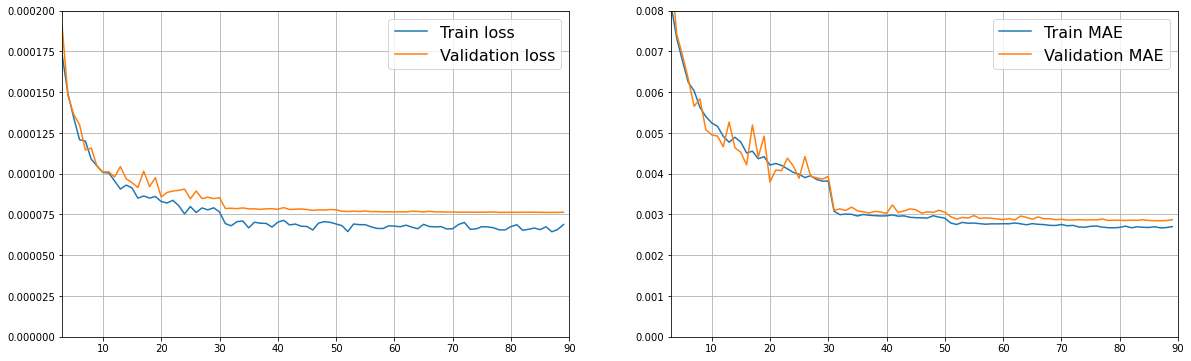

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
# Исключаем первые 3 итерации
axs[0].plot(history.history['loss'], label='Train loss')
axs[0].plot(history.history['val_loss'], label='Validation loss')
axs[0].grid(True)
axs[0].set_xlim([3, 90])
axs[0].set_ylim([0, 2e-4])
axs[0].legend(loc=1, prop={'size': 16})
axs[1].plot(history.history['mae'], label='Train MAE')
axs[1].plot(history.history['val_mae'], label='Validation MAE')
axs[1].grid(True)
axs[1].set_xlim([3, 90])
axs[1].set_ylim([0, .008])
axs[1].legend(loc=1, prop={'size': 16})
plt.show()

##### Проверка работы обученной модели

Проверяем работу модели на тестовой выборке.

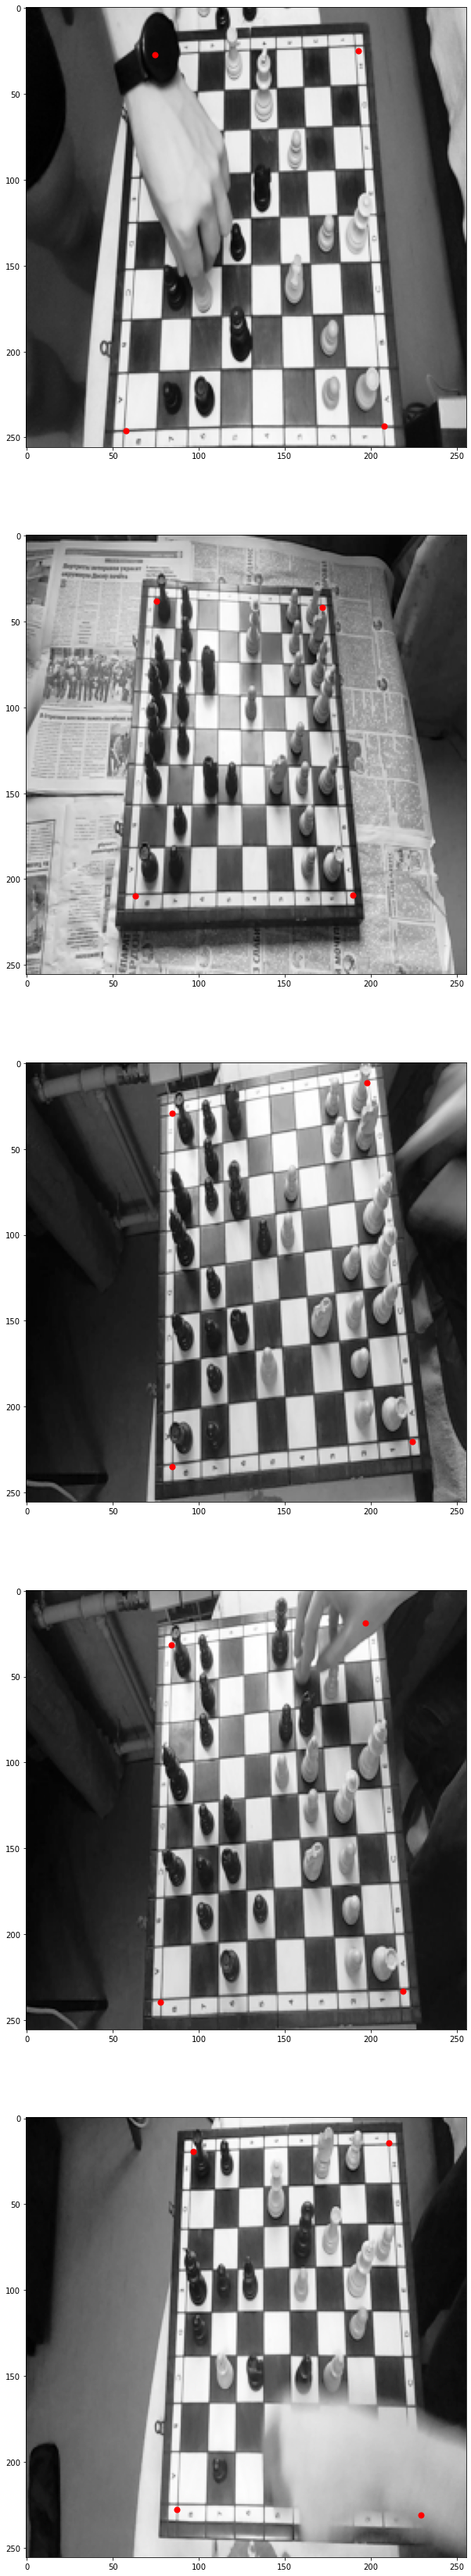

In [110]:
fig, axs = plt.subplots(5, 1, figsize=(20, 60))

for i in range(5):
    axs[i].imshow(x_test[i], cmap='Greys_r')

    predict = model.predict(x_test[i].reshape((1, IMG_SIZE, IMG_SIZE, 1)))

    axs[i].scatter(np.array([[predict[0][0], predict[0][2], predict[0][4], predict[0][6]]])*IMG_SIZE, 
                   np.array([[predict[0][1], predict[0][3], predict[0][5], predict[0][7]]])*IMG_SIZE, s=50, color='red')


Как видно, ключевые точки, вычисленные моделью, достаточно точно отмечают углы шахматного поля.